# Lung Segmentation

In [1]:
import numpy as np
import pandas as pd
import os
import glob
import cv2

# Imaging libraries
import matplotlib.pyplot as plt
%matplotlib inline
#import seaborn as sns
#p = sns.color_palette()
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

# Pandas configuration
pd.set_option('display.max_columns', None)
print('OK.')
print(cv2.__version__)

OK.
3.3.0


In [2]:
import dicom
dicom_root = 'data/Kaggle'
patients = [ x for x in os.listdir(dicom_root) if len(x)==32 ]
print('Patient count: {}'.format(len(patients)))

Patient count: 20


In [3]:
# DICOM rescale correction
def rescale_correction(s):
    s.image = s.pixel_array * s.RescaleSlope + s.RescaleIntercept

# Returns a list of images for that patient_id, in ascending order of Slice Location
# The pre-processed images are stored in ".image" attribute
def load_patient(patient_id):
    files = glob.glob(dicom_root + '/{}/*.dcm'.format(patient_id))
    slices = []
    for f in files:
        dcm = dicom.read_file(f)
        rescale_correction(dcm)
        # TODO: spacing eq.
        slices.append(dcm)
    
    slices = sorted(slices, key=lambda x: x.SliceLocation)
    return slices

# Segment and Visualize Lungs Scan

0acbebb8d463b4b9ca88cf38431aac69


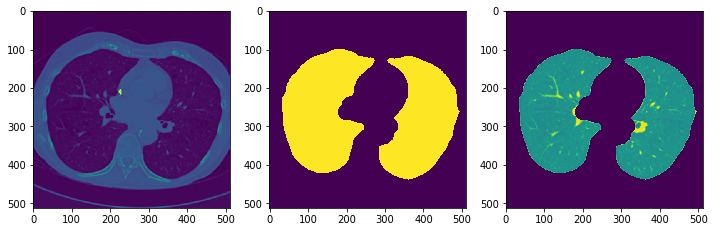

0d941a3ad6c889ac451caf89c46cb92a


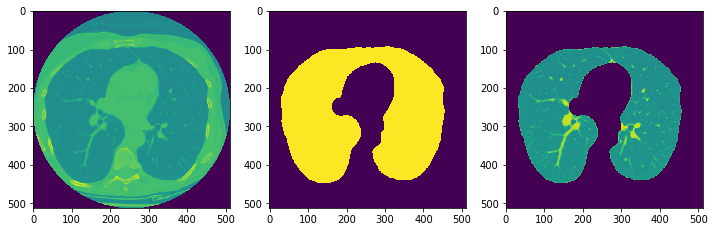

0bd0e3056cbf23a1cb7f0f0b18446068


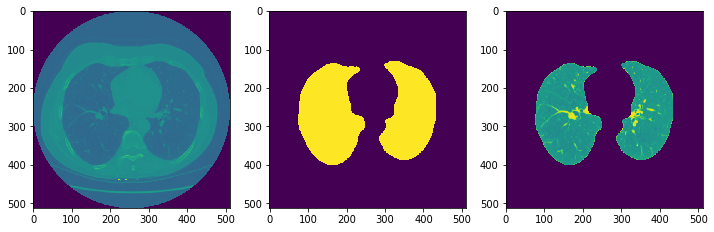

0d2fcf787026fece4e57be167d079383


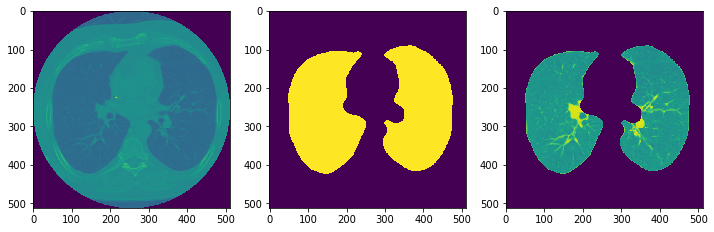

0c59313f52304e25d5a7dcf9877633b1


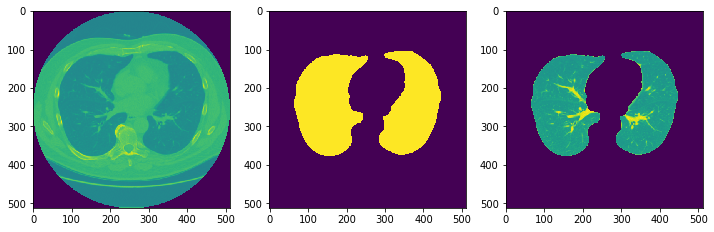

0a0c32c9e08cc2ea76a71649de56be6d


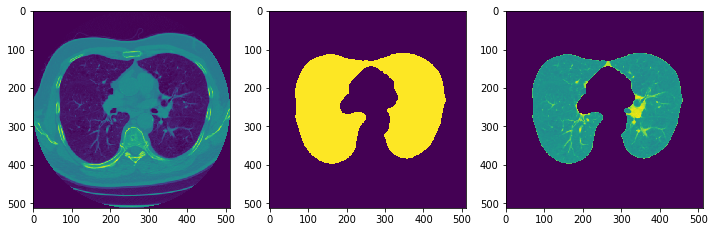

0ddeb08e9c97227853422bd71a2a695e


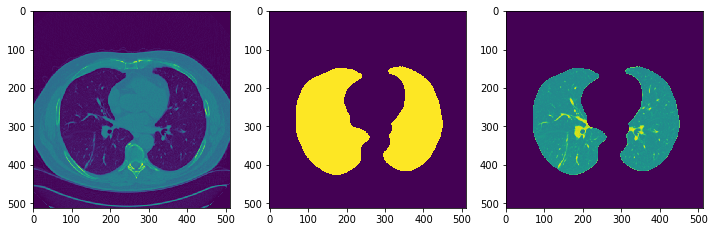

0c60f4b87afcb3e2dfa65abbbf3ef2f9


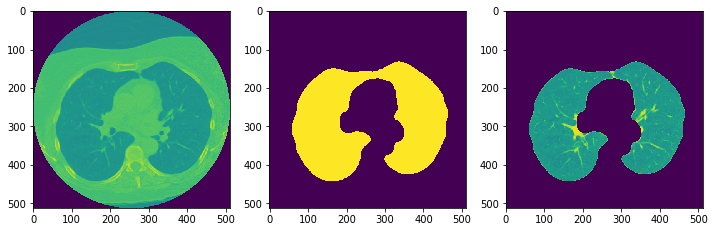

0a38e7597ca26f9374f8ea2770ba870d


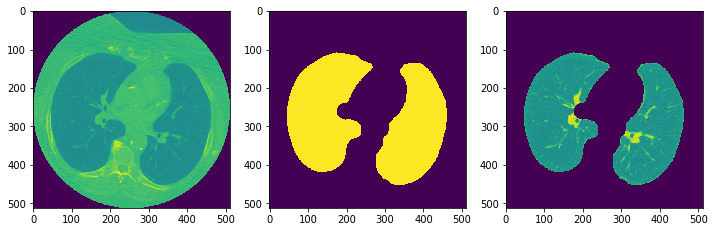

0d19f1c627df49eb223771c28548350e


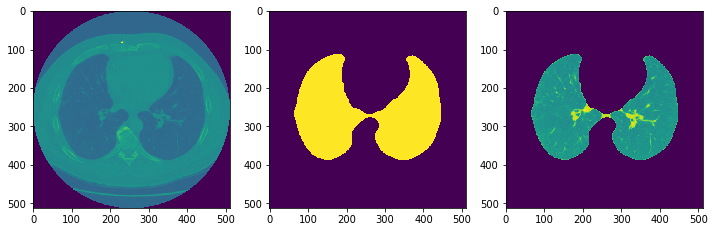

0d06d764d3c07572074d468b4cff954f


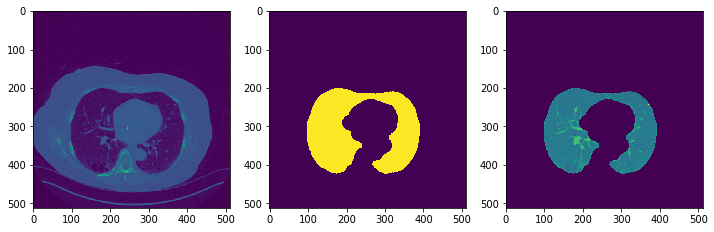

0a099f2549429d29b32f349e95fb2244


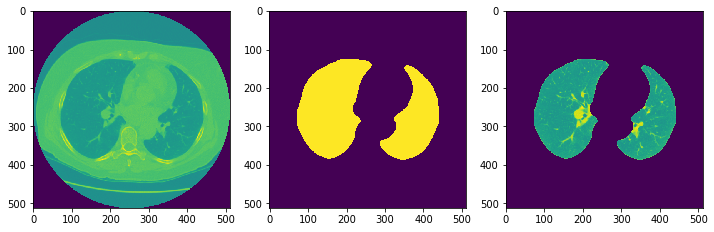

0c37613214faddf8701ca41e6d43f56e


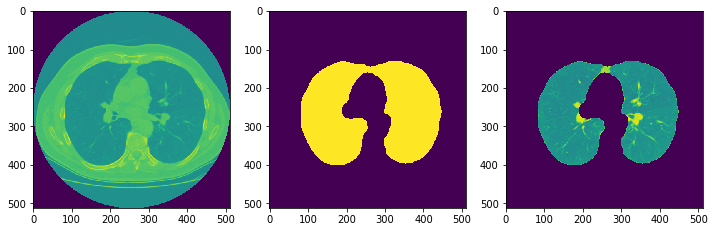

0c0de3749d4fe175b7a5098b060982a1


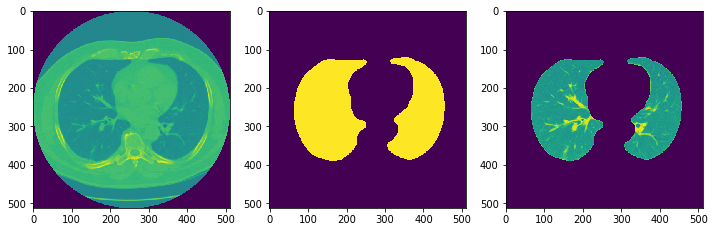

0ca943d821204ceb089510f836a367fd


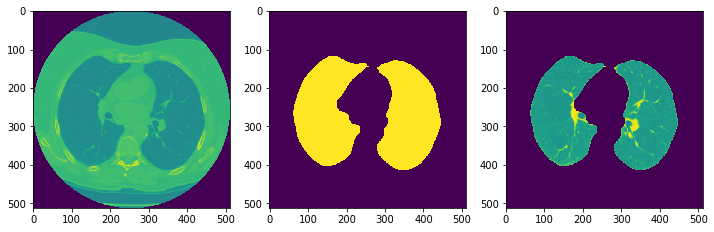

0de72529c30fe642bc60dcb75c87f6bd


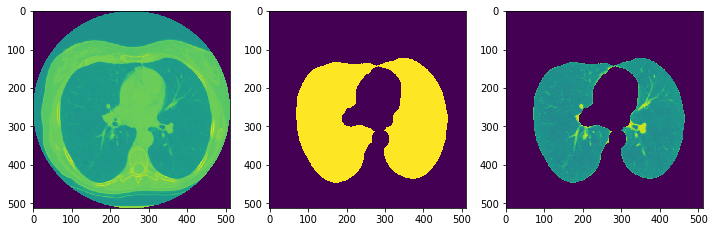

0c98fcb55e3f36d0c2b6507f62f4c5f1


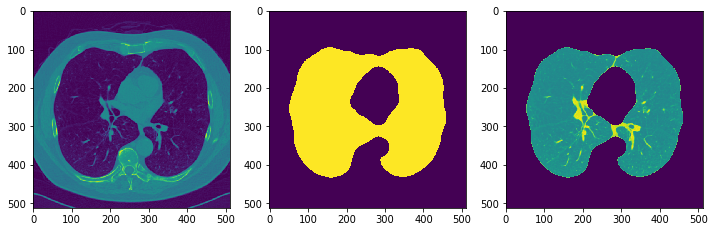

00cba091fa4ad62cc3200a657aeb957e


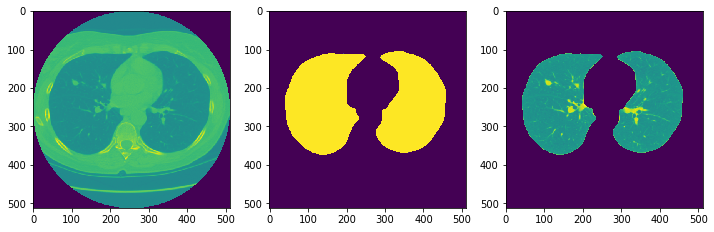

0c9d8314f9c69840e25febabb1229fa4


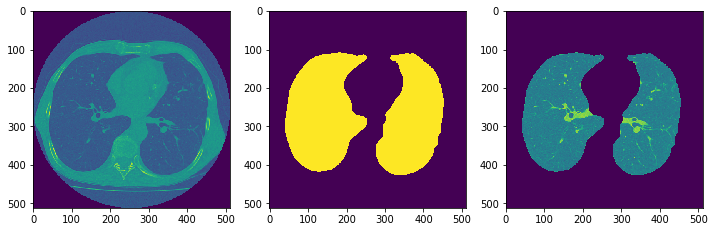

0b20184e0cd497028bdd155d9fb42dc9


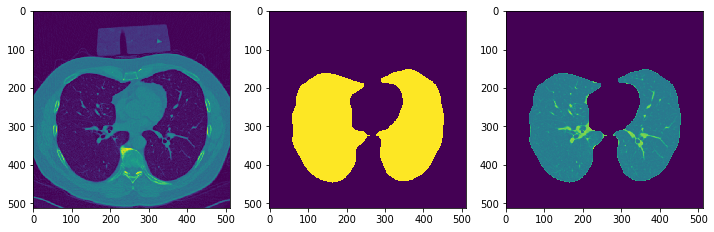

In [4]:
# Load a patient
for patient_no in patients:
    pat = load_patient(patient_no)
    print(patient_no)

    img = pat[ int(len(pat)/2) ].image.copy()

    # threshold HU > -300
    img[img>-300] = 255
    img[img<-300] = 0
    img = np.uint8(img)

    # find surrounding torso from the threshold and make a mask
    im2, contours, _ = cv2.findContours(img,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    mask = np.zeros(img.shape, np.uint8)
    cv2.fillPoly(mask, [largest_contour], 255)

    # apply mask to threshold image to remove outside. this is our new mask
    img = ~img
    img[(mask == 0)] = 0 # <-- Larger than threshold value

    # apply closing to the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(15,15))
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)  # <- to remove speckles...
    img = cv2.morphologyEx(img, cv2.MORPH_DILATE, kernel)
    img = cv2.morphologyEx(img, cv2.MORPH_DILATE, kernel)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    img = cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel)
    img = cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel)
    
    # apply mask to image
    img2 = pat[ int(len(pat)/2) ].image.copy()
    img2[(img == 0)] = -2000 # <-- Larger than threshold value

    # closing
    #sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
    #largest_contour = max(contours, key=cv2.contourArea)
    #rgb = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    #aaa = np.concatenate( sorted_contours[1:3] )
    #cv2.drawContours(rgb, [cv2.convexHull(aaa)], -1, (0,255,0), 3)

    plt.figure(figsize=(12, 12))
    plt.subplot(131)
    plt.imshow(pat[ int(len(pat)/2) ].image)
    plt.subplot(132)
    plt.imshow(img)
    plt.subplot(133)
    plt.imshow(img2)
    plt.show()